In [3]:

%pylab inline
#import mpld3
#mpld3.enable_notebook()

def hash_mavlink_files(filename):
    from sbp.msg import crc16
    fd = open(filename)
    buffer = fd.read(2048)
    return crc16(buffer)

class signal():
    """ Class to handle accessing dataframe values for each signal """
    def __init__(self, store, frame, field, maskkey=None, maskvalue=None):
        self.store = store
        self.frame = frame
        self.field = field
        self.mask = None
        if maskkey and maskvalue:
            self.mask = lambda x: x[maskkey] == maskvalue
    
    def _get_df(self):
        return self.store[self.frame].transpose()
    
    def _masked_indexes(self):
        return self.mask(self._get_df())
    
    def _return_series(self):
        return self._get_df()[self.field]
    
    def time_series(self):
        if self.mask:
            mask = self._masked_indexes()
            return self._return_series().loc[mask]
        else:
            return self._return_series()
        
    

Populating the interactive namespace from numpy and matplotlib


In [4]:
# Create and cache HDF5 Files which are intermediate consumable files for plotting

import subprocess
import os.path
mavlink_files = ['/Users/dzollo/Documents/ardupilot_logs/2.BIN.5']

tempfile_basedir = '/tmp/'
for eachfile in mavlink_files:
    print "Processing " + eachfile
    jsonfilename = os.path.join(tempfile_basedir,
                                os.path.split(eachfile)[-1] + str(hash_mavlink_files(eachfile)) + ".json"
                                )
    sbphdf5filename = os.path.join(tempfile_basedir,
                                   os.path.split(eachfile)[-1] + str(hash_mavlink_files(eachfile)) + ".hdf5"
                                   )
    mavlinkhdf5filename = os.path.join(tempfile_basedir,
                                        os.path.split(eachfile )[-1] + str(hash_mavlink_files(eachfile)) + ".m.hdf5"
                                       )
    try:
        if not os.path.isfile(jsonfilename):
            print "Creating sbp json file from mavlink dataflash log."
            print subprocess.check_output(['python','-m', 
                                           'piksi_tools.ardupilot.mavlink_decode' , eachfile, 
                                           '-o', jsonfilename], stderr=subprocess.STDOUT)
        else:
            print "Using cached sbp json file : {0}".format(jsonfilename)
        if not os.path.isfile(sbphdf5filename):
            print "Creating pandas hdf5 store from sbp json file."
            print subprocess.check_output(['python','-m', 
                                           'gnss_analysis.tools.records2table', jsonfilename, 
                                           '-o', sbphdf5filename], stderr=subprocess.STDOUT)
        else:
            print "Using cached sbp hdf5 store : {0}".format(sbphdf5filename)
        if not os.path.isfile(mavlinkhdf5filename):
            print "Creating pandas hdf5 store from mavlink dataflash log."
            print subprocess.check_output(['python','-m', 'piksi_tools.ardupilot.mavlink2pandas', eachfile, 
                                           '-o', mavlinkhdf5filename, '-t', 'GPS','GPS2', 'GPS_RAW','ORGN'], stderr=subprocess.STDOUT)
        else:
            print "Using cached mavlink hdf5 store : {0}".format(mavlinkhdf5filename)
    except subprocess.CalledProcessError as e:
        import traceback
        print traceback.format_exc()
        print e.output



Processing /Users/dzollo/Documents/ardupilot_logs/2.BIN.5
Creating sbp json file from mavlink dataflash log.
Skipped 1 bad bytes in log (10, 163, 149) remaining=215958
Skipped 1 bad bytes in log (10, 163, 149) remaining=215958
extracted 979 messages
Of 979 records, skipped 0.
JSON SBP log succesfully written to /tmp/2.BIN.511792.json.

Creating pandas hdf5 store from sbp json file.
/usr/local/lib/python2.7/site-packages/gnss_analysis-0.23-py2.7.egg/gnss_analysis/tools/records2table.py:372: UserWarning: base_obs is empty.
  warnings.warn('%s is empty.' % tab)
/usr/local/lib/python2.7/site-packages/gnss_analysis-0.23-py2.7.egg/gnss_analysis/tools/records2table.py:372: UserWarning: base_obs_integrity is empty.
  warnings.warn('%s is empty.' % tab)
/usr/local/lib/python2.7/site-packages/gnss_analysis-0.23-py2.7.egg/gnss_analysis/tools/records2table.py:372: UserWarning: rover_obs is empty.
  warnings.warn('%s is empty.' % tab)
/usr/local/lib/python2.7/site-packages/gnss_analysis-0.23-py2.7.

In [11]:
# Load existing HDF5 Files and display summary information
import pandas as pd
from gnss_analysis.hitl_table_utils import *
piksi = pd.HDFStore(sbphdf5filename) #sbphdf5filename)
mavlink = pd.HDFStore(mavlinkhdf5filename)
mavlink, piksi

(<class 'pandas.io.pytables.HDFStore'>
 File path: /tmp/2.BIN.511792.m.hdf5
 /GPS             frame        (shape->[1,140])
 /GPS2            frame        (shape->[1,483]),
 <class 'pandas.io.pytables.HDFStore'>
 File path: /tmp/2.BIN.511792.hdf5
 /MsgDops                        frame        (shape->[8,12])  
 /MsgHeartbeat                   frame        (shape->[3,29])  
 /MsgVelECEF                     frame        (shape->[9,111]) 
 /MsgVelNED                      frame        (shape->[10,111])
 /base_ephemerides               frame                         
 /base_obs                       frame                         
 /base_obs_integrity             frame                         
 /ephemerides                    frame                         
 /rover_acq                      frame                         
 /rover_ephemerides              frame                         
 /rover_iar_state                frame                         
 /rover_llh                      frame        (sh

In [6]:
# show different flight segments with corresponding indices in table.  
# A flight segment is defined as a gap of more than 10 seconds in pixhawk logged timestamps

# For pixhawk, use ublox timestamps, for piksi, use piksi GPSTime message timestamps

piksi_index_series = piksi

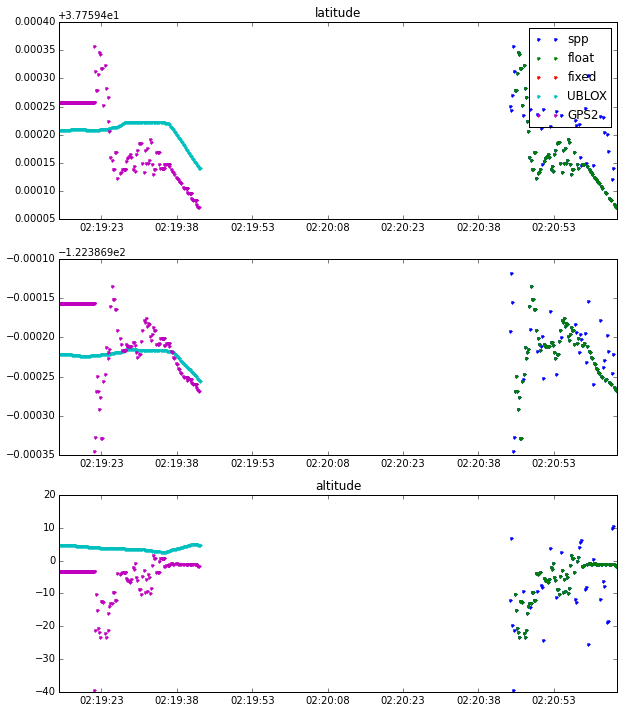

In [7]:
# add in some columns that will be needed for plotting
# Plot an arbitrary number of time histories with the same time vector on the x-axis
# lists of lists get zipped up to coplot
import numpy as np
import matplotlib.pylab as plt

#prepare piksi signals
spp_llh_lat = signal(piksi,'rover_llh', 'lat', 'flags', 0).time_series()[2:]
fixed_llh_lat = signal(piksi,'rover_llh', 'lat', 'flags', 1).time_series()[2:]
float_llh_lat = signal(piksi,'rover_llh', 'lat', 'flags', 2).time_series()[2:]
spp_llh_lon = signal(piksi,'rover_llh', 'lon', 'flags', 0).time_series()[2:]
fixed_llh_lon = signal(piksi,'rover_llh', 'lon', 'flags', 1).time_series()[2:]
float_llh_lon = signal(piksi,'rover_llh', 'lon', 'flags', 2).time_series()[2:]
spp_llh_alt = signal(piksi,'rover_llh', 'height', 'flags', 0).time_series()[2:]
fixed_llh_alt = signal(piksi,'rover_llh', 'height', 'flags', 1).time_series()[2:]
float_llh_alt = signal(piksi,'rover_llh', 'height', 'flags', 2).time_series()[2:]
spp_llh_ms = signal(piksi,'rover_llh', 'tow', 'flags', 0).time_series()[2:]
#prepare GPS1 signals
GPS1_llh_lat = signal(mavlink,'GPS', 'Lat', None, None).time_series()
GPS1_llh_lon = signal(mavlink,'GPS', 'Lng', None, None).time_series()
GPS1_llh_alt = signal(mavlink,'GPS', 'Alt', None, None).time_series()
GPS1_llh_ms = signal(mavlink,'GPS', 'GMS', None, None).time_series()
#prepare GPS2 signals
GPS2_llh_lat = signal(mavlink,'GPS2', 'Lat', None, None).time_series()
GPS2_llh_lon = signal(mavlink,'GPS2', 'Lng', None, None).time_series()
GPS2_llh_alt = signal(mavlink,'GPS2', 'Alt', None, None).time_series()



fig = plt.figure(figsize=[10,12])
ax1 = plt.subplot(3,1,1)
plt.plot(spp_llh_lat.index, spp_llh_lat, '.')
plt.plot(float_llh_lat.index, float_llh_lat, '.')
plt.plot(fixed_llh_lat.index, fixed_llh_lat, '.')
plt.plot(GPS1_llh_lat.index, GPS1_llh_lat, '.')
plt.plot(GPS2_llh_lat.index, GPS2_llh_lat, '.')
plt.legend(['spp','float','fixed', 'UBLOX', 'GPS2'])
plt.title('latitude')


ax2 = plt.subplot(3,1,2)
plt.plot(spp_llh_lon.index, spp_llh_lon, '.')
plt.plot(float_llh_lon.index, float_llh_lon, '.')
plt.plot(fixed_llh_lon.index, fixed_llh_lon, '.')
plt.plot(GPS1_llh_lon.index, GPS1_llh_lon, '.')
plt.plot(GPS2_llh_lon.index, GPS2_llh_lon, '.')
#plt.legend(['spp','float','fixed', 'UBLOX'])



ax3 = plt.subplot(3,1,3)
plt.title('longitude')
plt.plot(spp_llh_alt.index, spp_llh_alt, '.')
plt.plot(float_llh_alt.index, float_llh_alt, '.')
plt.plot(fixed_llh_alt.index, fixed_llh_alt, '.')
plt.plot(GPS1_llh_alt.index, GPS1_llh_alt, '.')
plt.plot(GPS2_llh_alt.index, GPS2_llh_alt, '.')
#plt.legend(['spp','float','fixed', 'UBLOX'])
plt.title('altitude')


In [8]:
#plt.plot(range(0, len(spp_llh_ms) ), spp_llh_ms)
#plt.plot(range(0, len(GPS1_llh_ms) ), GPS1_llh_ms/1000)

-122.3871212


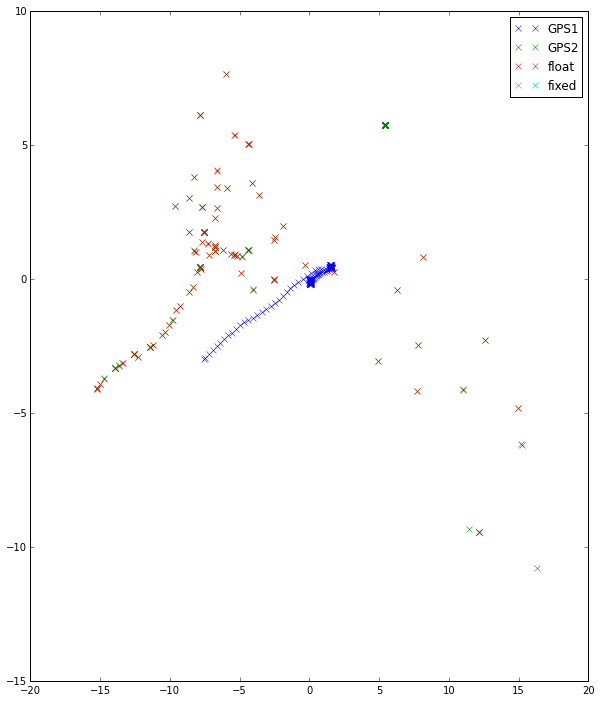

In [9]:
#plot ground tracks

def getNED(posns, ref):
    nedvect = np.zeros([len(posns),3])
    i = 0
    for eachlat, eachlon, eachalt in posns:
        ecef = wgsllh2ecef(eachlat * DEG2R, eachlon * DEG2R, eachalt)
        nedvect[i,:] = wgsecef2ned(ecef, ref)
        i+=1
    return nedvect

from swiftnav.coord_system import wgsecef2ned, wgsllh2ecef
import math
DEG2R = math.pi/180.0
print GPS1_llh_lon.iloc[0]

ref_posn =  wgsllh2ecef( GPS1_llh_lat.iloc[0] * DEG2R, 
                        GPS1_llh_lon.iloc[0] * DEG2R,  
                        GPS1_llh_alt.iloc[0])
GPS1NED = getNED(zip(GPS1_llh_lat, GPS1_llh_lon, GPS1_llh_alt), ref_posn)
GPS2NED = getNED(zip(GPS2_llh_lat, GPS2_llh_lon, GPS2_llh_alt), ref_posn)
floatned = getNED(zip(float_llh_lat, float_llh_lon, float_llh_alt), ref_posn)
fixedned = getNED(zip(fixed_llh_lat, fixed_llh_lon, fixed_llh_alt), ref_posn)

fig = plt.figure(figsize=[10,12])
plt.plot(GPS1NED[:,0],GPS1NED[:,1],'x')
plt.plot(GPS2NED[:,0],GPS2NED[:,1],'x')
plt.plot(floatned[:,0],floatned[:,1],'x')
plt.plot(fixedned[:,0],fixedned[:,1],'x')
plt.legend(['GPS1','GPS2','float','fixed'])

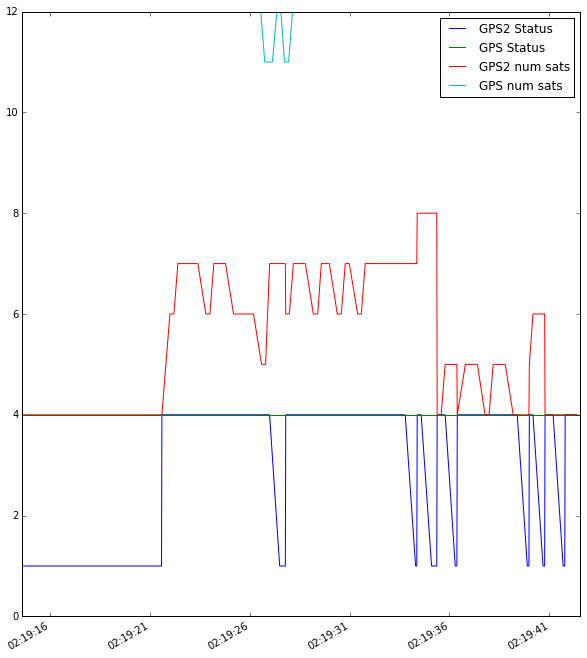

In [10]:
fig = plt.figure(figsize=[10,12])
GPS2_llh_lat = signal(mavlink,'GPS2', 'Status', None, None).time_series().plot()
GPS2_llh_lat = signal(mavlink,'GPS', 'Status', None, None).time_series().plot()
GPS2_llh_lat = signal(mavlink,'GPS2', 'NSats', None, None).time_series().plot()
GPS2_llh_lat = signal(mavlink,'GPS', 'NSats', None, None).time_series().plot()
plt.legend(['GPS2 Status', 'GPS Status', 'GPS2 num sats', 'GPS num sats'])